In [14]:
import pandas as pd
import numpy as np
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from pandas_datareader import DataReader

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [13.5,12]

In [15]:
bova11 = DataReader('BOVA11.SA','yahoo', datetime(2007, 12, 31))
bova11 = bova11.sort_values(by='Date')
bova11.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-12-02,35.810001,34.910000,35.110001,35.389999,759900.0,35.389999
2008-12-03,35.400002,33.900002,34.730000,35.310001,330100.0,35.310001
2008-12-04,36.000000,35.150002,35.799999,35.700001,128400.0,35.700001
2008-12-05,35.349998,34.110001,34.509998,35.349998,193700.0,35.349998
2008-12-08,38.459999,36.950001,37.349998,38.459999,103100.0,38.459999


## Historical drawdown

The stock market tends to rise over time, but that doesn't mean that you won't have periods of drawdown.

Drawdown can be measured as the percentage loss from the highest cumulative historical point.

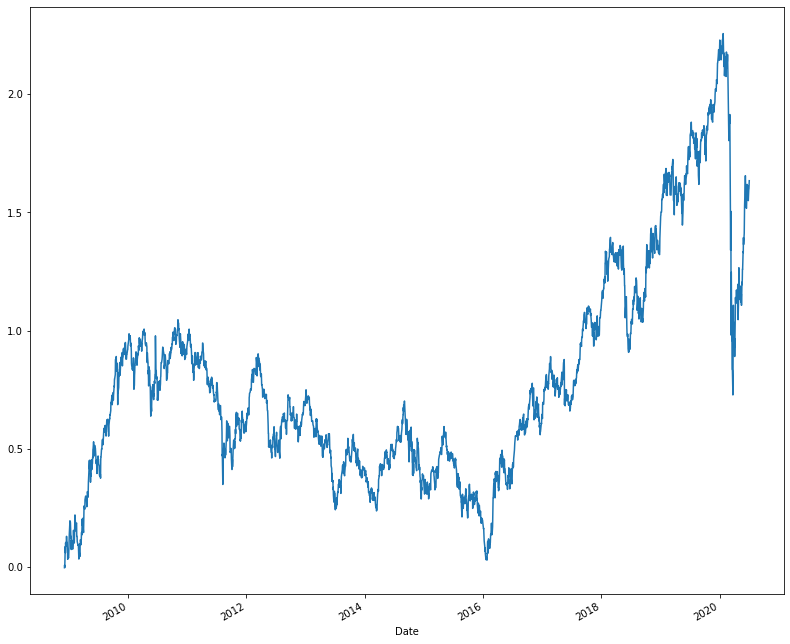

In [16]:
returns = bova11['Adj Close'].pct_change()
returns = returns.dropna()
cum_rets = ((1+returns).cumprod()-1)
cum_rets = cum_rets.dropna()

#Plot the returns
cum_rets.plot()
plt.show()

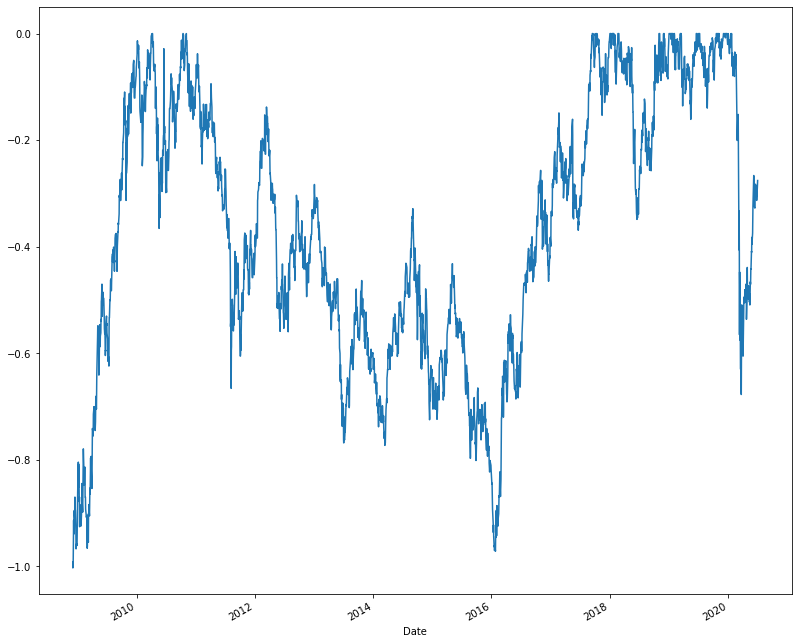

In [17]:
# Calculate the running maximum
running_max = np.maximum.accumulate(cum_rets)

# Ensure the value never drops below 1
running_max[running_max<1] = 1

# Calculate the percentage drawdown
drawdown = (cum_rets)/running_max - 1

# Plot the results
drawdown.plot()
plt.show()

Notice how the drawdown never goes above 0 (as opposed to the previous plot)? That's because a positive drawdown isn't a drawdown at all - its a gain!

## Historical value at risk

Drawdown is a measure of sustained losses over time, but what about simple single-day movements?

Value at Risk, often referred to as VaR, is a way to estimate the risk of a single day negative price movement. VaR can be measured for any given probability, or confidence level, but the most commonly quoted tend to be VaR(95) and VaR(99). Historical VaR is the simplest method to calculate VaR, but relies on historical returns data which may not be a good assumption of the future. Historical VaR(95), for example, represents the minimum loss that our portfolio or asset has sustained in the worst 5% of cases.

Historical VaR(95) = -2.43%


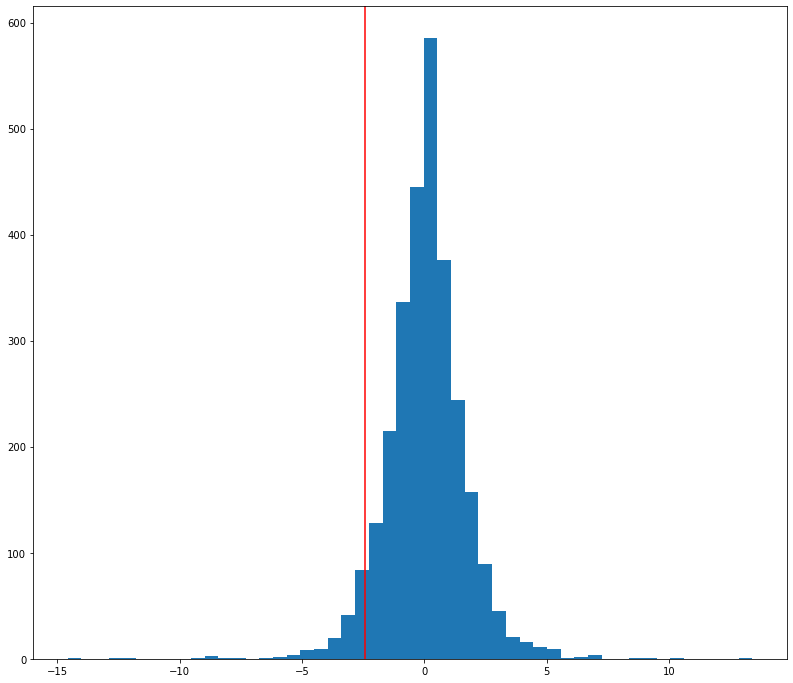

In [18]:
# Calculate historical VaR(95)
returns_perc = returns*100
var_95 = np.quantile(returns_perc, 0.05)
print('Historical VaR(95) = {0:.2f}%'.format(var_95))

# Sort the returns for plotting
sorted_rets = returns_perc.sort_values()

# Plot the probability of each sorted return quantile
plt.hist(sorted_rets, bins=50)

# Denote the VaR 95 quantile
plt.axvline(x=var_95, color='r', linestyle='-', label="VaR 95: {0:.2f}%".format(var_95))
plt.show()

## Historical expected shortfall

Expected Shortfall, otherwise known as CVaR, or conditional value at risk, is simply the expected loss of the worst case scenarios of returns.

For example, if your portfolio has a VaR(95) of -3%, then the CVaR(95) would be the average value of all losses exceeding -3%.

-3.714326082690498


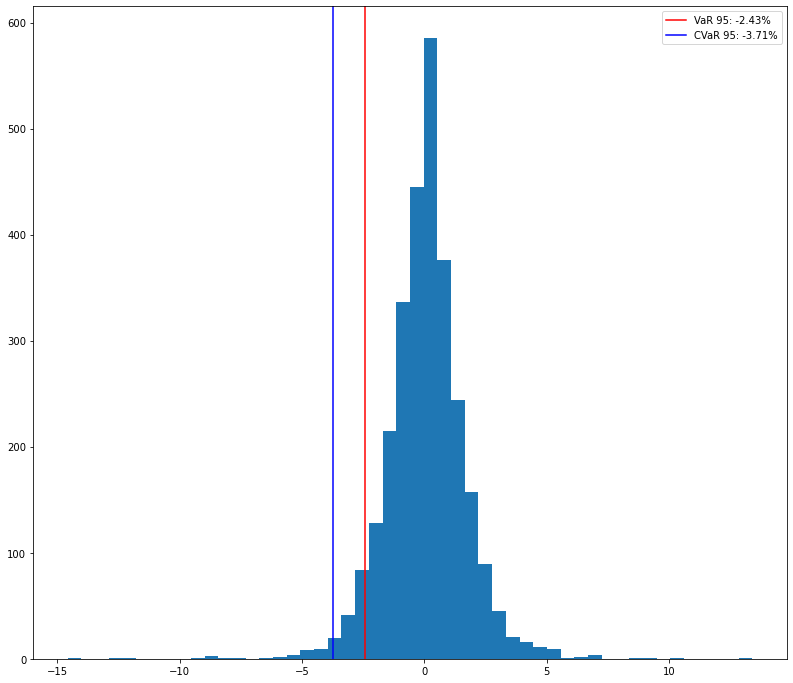

In [19]:
# Historical CVaR 95
cvar_95 = returns_perc[returns_perc <= var_95].mean()
print(cvar_95)

# Sort the returns for plotting
sorted_rets = sorted(returns_perc)

# Plot the probability of each return quantile
plt.hist(sorted_rets, bins=50)

# Denote the VaR 95 and CVaR 95 quantiles
plt.axvline(x=var_95, color="r", linestyle="-", label='VaR 95: {0:.2f}%'.format(var_95))
plt.axvline(x=cvar_95, color='b', linestyle='-', label='CVaR 95: {0:.2f}%'.format(cvar_95))
plt.legend()
plt.show()

## Changing VaR and CVaR quantiles

VaR quantiles often used are 90%, 95%, and 99%, corresponding to the worst 10%, 5%, and 1% of cases respectively. These same quantiles are also often used for CVaR. Note that CVaR will always be a more extreme estimate when compared with VaR for the same quantile.

-1.7822866409268068
-2.908610957294855
-4.103791461584262
-6.559010181653813


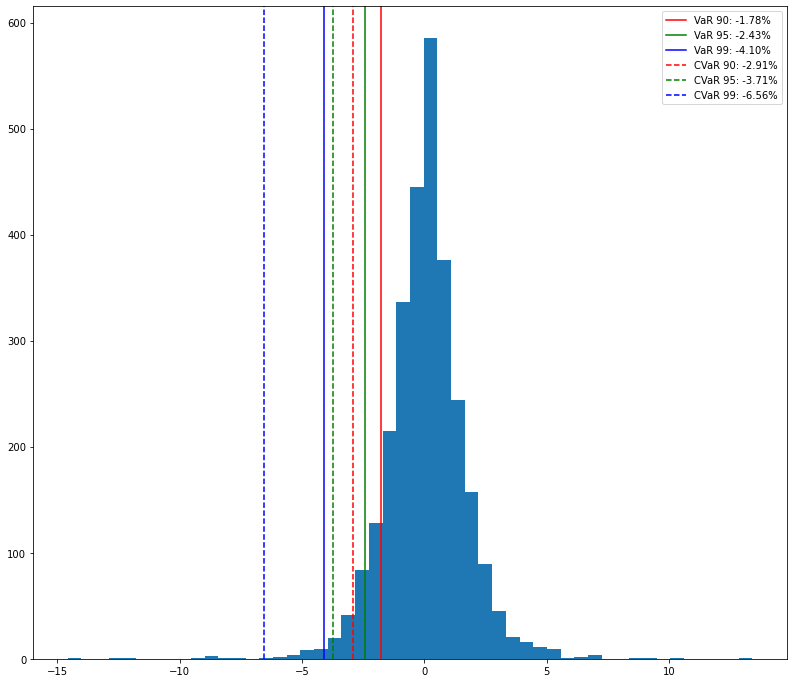

In [20]:
# Historical VaR(90) quantiles
var_90 = np.quantile(returns_perc, 0.1)
print(var_90)

# Historical CVaR(90) quantiles
cvar_90 = returns_perc[returns_perc<=var_90].mean()
print(cvar_90)

# Historical VaR(99) quantiles
var_99 = np.quantile(returns_perc, 0.01)
print(var_99)

# Historical CVaR(99) quantiles
cvar_99 = returns_perc[returns_perc<=var_99].mean()
print(cvar_99)

# Plot the probability of each return quantile
plt.hist(sorted_rets, bins=50)

# Denote the VaR and CVaR quantiles
plt.axvline(x=var_90, color="r", linestyle="-", label='VaR 90: {0:.2f}%'.format(var_90))
plt.axvline(x=var_95, color="g", linestyle="-", label='VaR 95: {0:.2f}%'.format(var_95))
plt.axvline(x=var_99, color="b", linestyle="-", label='VaR 99: {0:.2f}%'.format(var_99))

plt.axvline(x=cvar_90, color='r', linestyle='dashed', label='CVaR 90: {0:.2f}%'.format(cvar_90))
plt.axvline(x=cvar_95, color='g', linestyle='dashed', label='CVaR 95: {0:.2f}%'.format(cvar_95))
plt.axvline(x=cvar_99, color='b', linestyle='dashed', label='CVaR 99: {0:.2f}%'.format(cvar_99))

plt.legend()
plt.show()

## Parametric VaR

Value at Risk can also be computed parametrically using a method known as variance/co-variance VaR. This method allows you to simulate a range of possibilities based on historical return distribution properties rather than actual return values. 

In [21]:
# Import norm from scipy.stats
from scipy.stats import norm 

# Estimate the average daily return
mu = np.mean(returns)

# Estimate the daily volatility
vol = np.std(returns)

# Set the VaR confidence level
confidence_level = 0.05

# Calculate Parametric VaR
var_95 = norm.ppf(confidence_level, mu, vol)
print('Mean: ', str(mu), '\nVolatility: ', str(vol), '\nVaR(95): ', str(var_95))

Mean:  0.000478160165658007 
Volatility:  0.016724386227270842 
VaR(95):  -0.0270310071788057


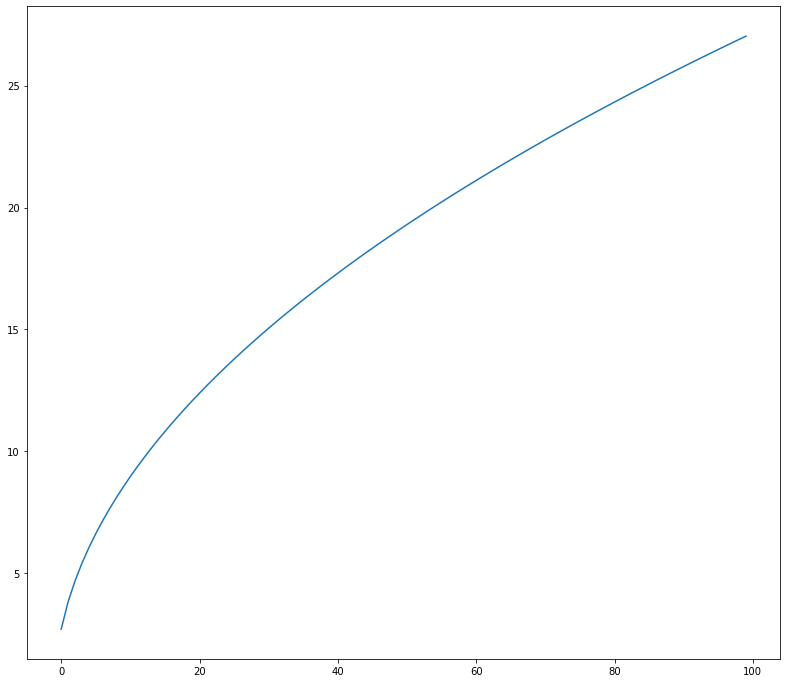

In [22]:
# Aggregate forecasted VaR
forecasted_values = np.empty([100, 2])

# Loop through each forecast period
for i in range(100):
    # Save the time horizon i
    forecasted_values[i, 0] = i
    # Save the forecasted VaR 95
    forecasted_values[i, 1] = var_95*np.sqrt(i+1)
    
plt.plot(forecasted_values[:,0],forecasted_values[:,1]*-100)
plt.show()

## A random walk simulation

Stochastic or random movements are used in physics to represent particle and fluid movements, in mathematics to describe fractal behavior, and in finance to describe stock market movements.

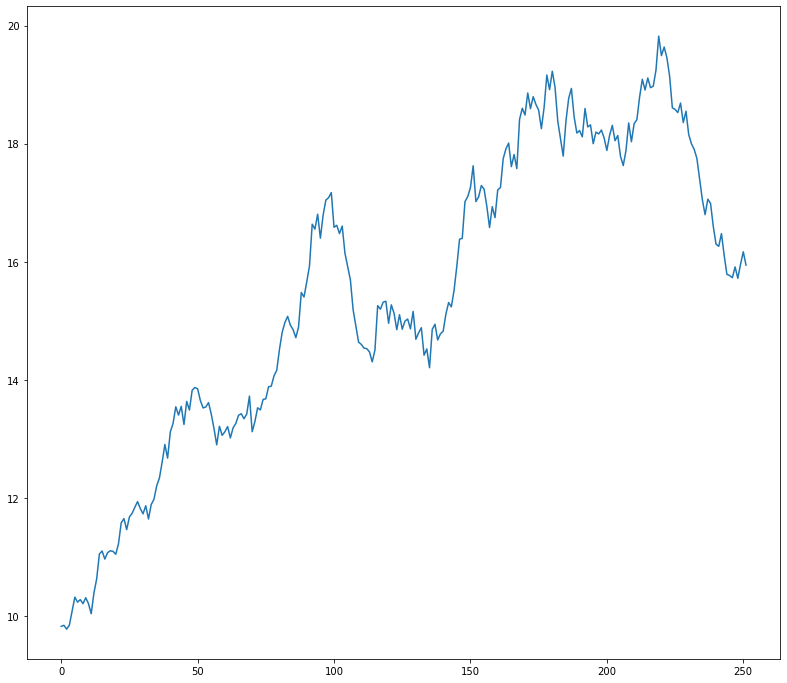

In [23]:
# Set the simulation parameters
mu = np.mean(returns)
vol = np.std(returns)
T = 252
S0 = 10

# Add one to the random returns
rand_rets = np.random.normal(mu, vol, T) + 1

# Forecasted random walk
forecasted_values = S0*rand_rets.cumprod()

# Plot the random walk
plt.plot(range(0, T), forecasted_values)
plt.show()

## Monte Carlo simulations

Monte-Carlo simulations are used to model a wide range of possibilities.

Monte-Carlos can be constructed in many different ways, but all of them involve generating a large number of random variants of a given model, allowing a wide distribution of possible paths to be analyzed. This can allow you to build a comprehensive forecast of possibilities to sample from without a large amount of historical data.

Generate 100 Monte-Carlo simulations for the USO oil ETF.

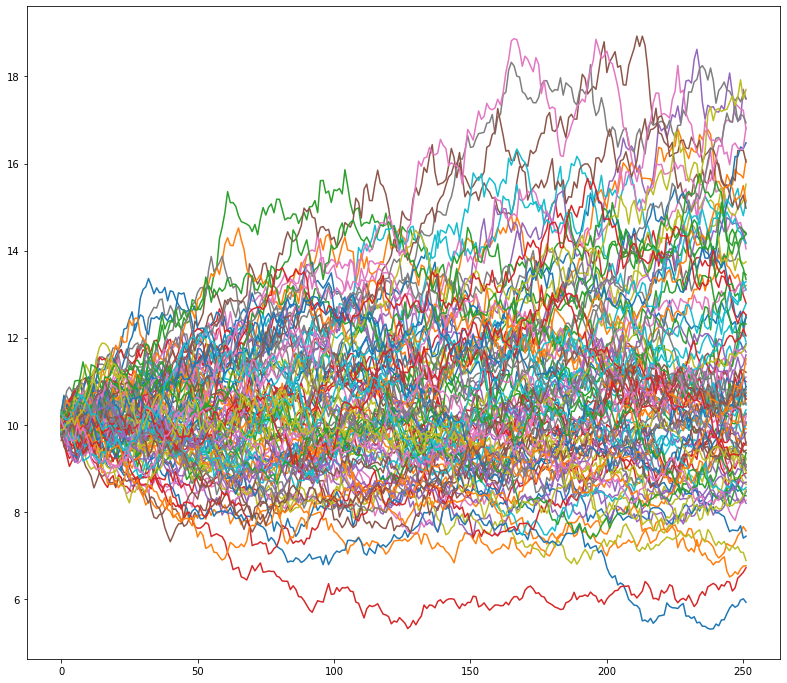

In [24]:
for i in range(100):

    # Generate the random returns
    rand_rets = np.random.normal(mu, vol, T) + 1
    
    # Create the Monte carlo path
    forecasted_values = S0*(rand_rets).cumprod()
    
    # Plot the Monte Carlo path
    plt.plot(range(T), forecasted_values)

# Show the simulations
plt.show()

## Monte Carlo VaR

Both the return values and the Monte-Carlo paths can be used for analysis of everything ranging from option pricing models and hedging to portfolio optimization and trading strategies.

Aggregate the returns data at each iteration, and use the resulting values to forecast parametric VaR(99).

In [25]:
# Aggregate the returns
sim_returns = []

# Loop through 100 simulations
for i in range(100):

    # Generate the Random Walk
    rand_rets = np.random.normal(mu, vol, T)
    
    # Save the results
    sim_returns.append(rand_rets)

# Calculate the VaR(99)
var_99 = np.percentile(sim_returns, 1)
print("Parametric VaR(99): ", round(100*var_99, 2),"%")

Parametric VaR(99):  -3.86 %
